<a href="https://colab.research.google.com/github/Sudin2001/Project-Of-ML/blob/main/Revenue_of_Aeroplane.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

booking_data = pd.read_csv("/content/drive/MyDrive/booking_data.csv")
inventory_data = pd.read_csv("/content/drive/MyDrive/inventory_data.csv")
competitor_data = pd.read_csv("/content/drive/MyDrive/competitor_pricing_data.csv")

In [ ]:
booking_data.head()

,Booking ID,Flight Number,Date of Booking,Travel Date,Fare Class,Price,Seats Booked,Channel
0,B63032,FL100,2025-05-19,2025-05-22,Economy,400.21,3,Web
1,B60060,FL100,2025-05-18,2025-05-22,Economy,346.57,2,Agent
2,B62690,FL100,2025-05-05,2025-05-22,Business,339.37,1,Web
3,B90229,FL100,2025-05-12,2025-05-22,Economy,231.38,3,Agent
4,B36959,FL100,2025-05-08,2025-05-22,Premium Economy,468.72,1,Web


In [ ]:
inventory_data.head()

,Flight Number,Date,Aircraft Type,Total Seats,Booked Seats,Remaining Seats
0,FL100,5/22/2025,B737,180,150,30
1,FL100,5/23/2025,B737,180,147,33
2,FL100,5/24/2025,A321,180,121,59
3,FL100,5/25/2025,B737,180,154,26
4,FL100,5/26/2025,A320,180,117,63


In [ ]:
competitor_data.head()

,Date,Flight Number,Competitor,Fare Class,Price
0,2025-05-22,FL100,Delta,Economy,359.97
1,2025-05-22,FL100,Delta,Premium Economy,357.01
2,2025-05-22,FL100,Delta,Business,302.36
3,2025-05-22,FL100,United,Economy,106.89
4,2025-05-22,FL100,United,Premium Economy,468.80


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

In [ ]:
print(f"Inventory data shape: {inventory_data.shape}")
print(f"Competitor data shape: {competitor_data.shape}")
print(f"Booking data shape: {booking_data.shape}")

Inventory data shape: (300, 6)
Competitor data shape: (2700, 5)
Booking data shape: (2963, 8)


In [ ]:
# Step 1: Data Cleaning and Preparation
print("\n=== STEP 1: DATA CLEANING ===")

# Clean inventory data
inventory_data['Date'] = pd.to_datetime(inventory_data['Date'])
inventory_data = inventory_data.dropna()
# Clean competitor data
competitor_data['Date'] = pd.to_datetime(competitor_data['Date'])
competitor_data = competitor_data.dropna()

# Clean booking data
booking_data['Date of Booking'] = pd.to_datetime(booking_data['Date of Booking'])
booking_data['Travel Date'] = pd.to_datetime(booking_data['Travel Date'])
booking_data = booking_data.dropna()


=== STEP 1: DATA CLEANING ===


In [ ]:
# Calculate average competitor prices by flight and date
competitor_avg = competitor_data.groupby(['Date', 'Flight Number', 'Fare Class'])['Price'].mean().reset_index()
competitor_avg.rename(columns={'Price': 'Competitor_Avg_Price'}, inplace=True)

In [ ]:
# First merge inventory with booking data
merged_data = inventory_data.merge(
    booking_data,
    left_on=['Flight Number', 'Date'],
    right_on=['Flight Number', 'Travel Date'],
    how='left'
)

In [ ]:
# Add competitor pricing data
merged_data = merged_data.merge(
    competitor_avg,
    left_on=['Date', 'Flight Number', 'Fare Class'],
    right_on=['Date', 'Flight Number', 'Fare Class'],
    how='left'
)

In [ ]:
# Calculate revenue (our target variable)
merged_data['Revenue'] = merged_data['Price'] * merged_data['Seats Booked']
merged_data['Revenue'].fillna(0, inplace=True)

In [ ]:
# Fill missing competitor prices with median
merged_data['Competitor_Avg_Price'].fillna(
    merged_data['Competitor_Avg_Price'].median(),
    inplace=True
)
print("Data cleaning completed!")
print(f"Final merged data shape: {merged_data.shape}")


Data cleaning completed!
Final merged data shape: (2963, 15)


In [ ]:
merged_data.head()

,Flight Number,Date,Aircraft Type,Total Seats,Booked Seats,Remaining Seats,Booking ID,Date of Booking,Travel Date,Fare Class,Price,Seats Booked,Channel,Competitor_Avg_Price,Revenue
0,FL100,2025-05-22,B737,180,150,30,B63032,2025-05-19,2025-05-22,Economy,400.21,3,Web,248.296667,1200.63
1,FL100,2025-05-22,B737,180,150,30,B60060,2025-05-18,2025-05-22,Economy,346.57,2,Agent,248.296667,693.14
2,FL100,2025-05-22,B737,180,150,30,B62690,2025-05-05,2025-05-22,Business,339.37,1,Web,252.423333,339.37
3,FL100,2025-05-22,B737,180,150,30,B90229,2025-05-12,2025-05-22,Economy,231.38,3,Agent,248.296667,694.14
4,FL100,2025-05-22,B737,180,150,30,B36959,2025-05-08,2025-05-22,Premium Economy,468.72,1,Web,322.560000,468.72


In [ ]:
# Step 2: Feature Engineering and Encoding
print("\n=== STEP 2: FEATURE ENGINEERING & ENCODING ===")

# Create additional features
merged_data['Load_Factor'] = merged_data['Booked Seats'] / merged_data['Total Seats']
merged_data['Days_Before_Travel'] = (merged_data['Travel Date'] - merged_data['Date of Booking']).dt.days
merged_data['Month'] = merged_data['Date'].dt.month
merged_data['Day_of_Week'] = merged_data['Date'].dt.dayofweek
merged_data['Price_vs_Competitor'] = merged_data['Price'] / merged_data['Competitor_Avg_Price']


=== STEP 2: FEATURE ENGINEERING & ENCODING ===


In [ ]:
# Handle missing values in new features
merged_data['Days_Before_Travel'].fillna(merged_data['Days_Before_Travel'].median(), inplace=True)
merged_data['Price_vs_Competitor'].fillna(1.0, inplace=True)

In [ ]:
# Encoding categorical variables
label_encoders = {}
categorical_cols = ['Aircraft Type', 'Fare Class', 'Channel', 'Flight Number']

for col in categorical_cols:
    if col in merged_data.columns:
        le = LabelEncoder()
        merged_data[f'{col}_Encoded'] = le.fit_transform(merged_data[col].astype(str))
        label_encoders[col] = le

print("Encoding completed!")


Encoding completed!


In [ ]:
# Prepare feature matrix and target
feature_cols = [
    'Total Seats', 'Booked Seats', 'Remaining Seats', 'Price',
    'Seats Booked', 'Load_Factor', 'Days_Before_Travel',
    'Month', 'Day_of_Week', 'Competitor_Avg_Price', 'Price_vs_Competitor',
    'Aircraft Type_Encoded', 'Fare Class_Encoded', 'Channel_Encoded', 'Flight Number_Encoded'
]

In [ ]:
# Filter available columns
available_cols = [col for col in feature_cols if col in merged_data.columns]
X = merged_data[available_cols].copy()
y = merged_data['Revenue'].copy()

In [ ]:
# Remove rows with missing target values
mask = ~y.isna()
X = X[mask]
y = y[mask]

In [ ]:
# Fill remaining missing values
X = X.fillna(X.median())

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

Feature matrix shape: (2963, 15)
Target vector shape: (2963,)


In [ ]:
# Step 3: Train-Test Split
print("\n=== STEP 3: TRAIN-TEST SPLIT ===")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


=== STEP 3: TRAIN-TEST SPLIT ===
Training set size: 2370
Test set size: 593


In [ ]:
# Step 4: Model Training and Evaluation
print("\n=== STEP 4: MODEL TRAINING & EVALUATION ===")


=== STEP 4: MODEL TRAINING & EVALUATION ===


In [ ]:
# Initialize models
models = {
    'Decision Tree': DecisionTreeRegressor(random_state=42, max_depth=10),
    'Random Forest': RandomForestRegressor(random_state=42, n_estimators=100, max_depth=10)
}

results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    # Train model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)


Training Decision Tree...

Training Random Forest...


In [ ]:
# Calculate metrics
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)
test_mae = mean_absolute_error(y_test, y_pred_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

results[name] = {
    'model': model,
    'train_r2': train_r2,
    'test_r2': test_r2,
    'mae': test_mae,
    'rmse': test_rmse
}
print(f"Train R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")
print(f"MAE: {test_mae:.2f}")
print(f"RMSE: {test_rmse:.2f}")

Train R²: 1.0000
Test R²: 1.0000
MAE: 0.74
RMSE: 1.09


In [ ]:
# Step 5: Select Best Model
print("\n=== STEP 5: BEST MODEL SELECTION ===")

best_model_name = max(results.keys(), key=lambda x: results[x]['test_r2'])
best_model = results[best_model_name]['model']

print(f"Best Model: {best_model_name}")
print(f"Best R² Score: {results[best_model_name]['test_r2']:.4f}")
print(f"Best MAE: {results[best_model_name]['mae']:.2f}")
print(f"Best RMSE: {results[best_model_name]['rmse']:.2f}")


=== STEP 5: BEST MODEL SELECTION ===
Best Model: Random Forest
Best R² Score: 1.0000
Best MAE: 0.74
Best RMSE: 1.09


In [ ]:
# Step 6: Feature Importance Analysis
print("\n=== STEP 6: FEATURE IMPORTANCE ANALYSIS ===")

if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)

    print("Top 10 Most Important Features:")
    print(feature_importance.head(10))


=== STEP 6: FEATURE IMPORTANCE ANALYSIS ===
Top 10 Most Important Features:
                  feature  importance
4            Seats Booked    0.507420
3                   Price    0.492560
6      Days_Before_Travel    0.000002
10    Price_vs_Competitor    0.000002
2         Remaining Seats    0.000002
9    Competitor_Avg_Price    0.000002
14  Flight Number_Encoded    0.000002
1            Booked Seats    0.000002
8             Day_of_Week    0.000002
5             Load_Factor    0.000002


Text(0.5, 0, 'Importance Score')

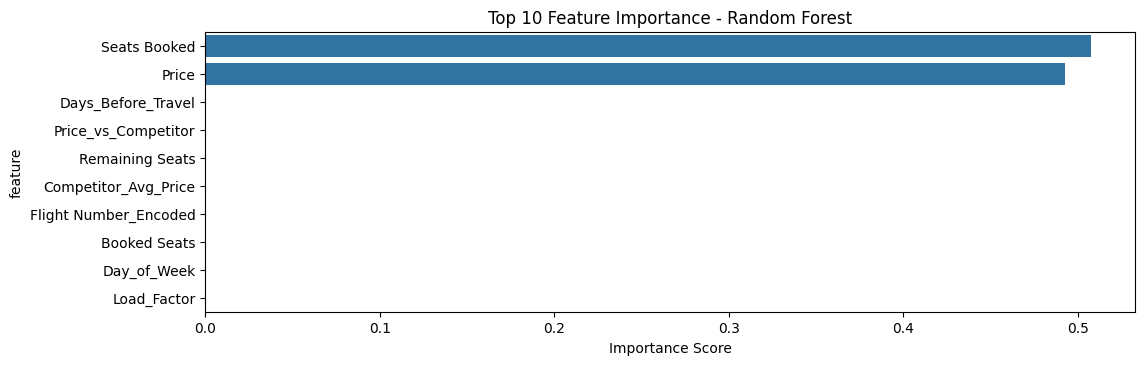

In [ ]:
# Plot feature importance
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
plt.title(f'Top 10 Feature Importance - {best_model_name}')
plt.xlabel('Importance Score')

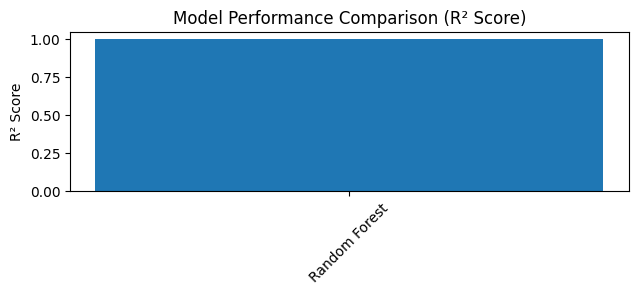

In [ ]:
# Model performance comparison
plt.subplot(2, 1, 2)
model_names = list(results.keys())
r2_scores = [results[name]['test_r2'] for name in model_names]

plt.bar(model_names, r2_scores)
plt.title('Model Performance Comparison (R² Score)')
plt.ylabel('R² Score')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
# Step 7: Revenue Analysis and Optimization
print("\n=== STEP 7: REVENUE ANALYSIS & OPTIMIZATION ===")

# Current revenue analysis
current_revenue = merged_data['Revenue'].sum()
avg_revenue_per_flight = merged_data.groupby('Flight Number')['Revenue'].mean()
print(f"Current Total Revenue: ${current_revenue:,.2f}")
print(f"Average Revenue per Flight: ${avg_revenue_per_flight.mean():,.2f}")



=== STEP 7: REVENUE ANALYSIS & OPTIMIZATION ===
Current Total Revenue: $1,799,256.15
Average Revenue per Flight: $606.81


In [ ]:
# Revenue optimization simulation
print("\nRevenue Optimization Simulation:")

# Create scenarios for optimization
optimization_scenarios = []


Revenue Optimization Simulation:


In [ ]:
# Scenario 1: Optimize pricing based on competitor prices
X_optimized_price = X.copy()
price_col = 'Price'
competitor_col = 'Competitor_Avg_Price'

if price_col in X_optimized_price.columns and competitor_col in X_optimized_price.columns:
    # Increase price by 5% when competitor price is higher
    price_increase_mask = X_optimized_price[competitor_col] > X_optimized_price[price_col]
    X_optimized_price.loc[price_increase_mask, price_col] *= 1.05

In [ ]:
# Scenario 2: Optimize load factor
X_optimized_load = X.copy()
load_factor_col = 'Load_Factor'

if load_factor_col in X_optimized_load.columns:
    # Improve load factor by 10% for flights with low load factor
    low_load_mask = X_optimized_load[load_factor_col] < 0.8
    X_optimized_load.loc[low_load_mask, load_factor_col] *= 1.1
    X_optimized_load.loc[:, load_factor_col] = np.clip(X_optimized_load.loc[:, load_factor_col], 0, 1)

In [ ]:
# Predict optimized revenues
scenarios = {
    'Current': X,
    'Optimized_Pricing': X_optimized_price,
    'Optimized_Load_Factor': X_optimized_load
}

scenario_results = {}
for scenario_name, scenario_data in scenarios.items():
    predicted_revenue = best_model.predict(scenario_data)
    total_predicted_revenue = predicted_revenue.sum()
    scenario_results[scenario_name] = total_predicted_revenue

In [ ]:
# Calculate revenue increases
base_revenue = scenario_results['Current']
price_optimization_increase = scenario_results['Optimized_Pricing'] - base_revenue
load_optimization_increase = scenario_results['Optimized_Load_Factor'] - base_revenue

print(f"\nRevenue Optimization Results:")
print(f"Current Predicted Revenue: ${base_revenue:,.2f}")
print(f"Price Optimization Revenue: ${scenario_results['Optimized_Pricing']:,.2f}")
print(f"Load Factor Optimization Revenue: ${scenario_results['Optimized_Load_Factor']:,.2f}")
print(f"\nRevenue Increases:")
print(f"Price Optimization Increase: ${price_optimization_increase:,.2f} ({price_optimization_increase/base_revenue*100:.2f}%)")
print(f"Load Factor Optimization Increase: ${load_optimization_increase:,.2f} ({load_optimization_increase/base_revenue*100:.2f}%)")


Revenue Optimization Results:
Current Predicted Revenue: $1,799,200.87
Price Optimization Revenue: $1,829,504.14
Load Factor Optimization Revenue: $1,799,196.38

Revenue Increases:
Price Optimization Increase: $30,303.27 (1.68%)
Load Factor Optimization Increase: $-4.49 (-0.00%)


In [ ]:
# Step 8: Recommendations and Summary
print("\n=== STEP 8: RECOMMENDATIONS & SUMMARY ===")

print("\n PROJECT SUMMARY:")
print(f" Best Model: {best_model_name} with R² = {results[best_model_name]['test_r2']:.4f}")
print(f" Current Revenue: ${current_revenue:,.2f}")
print(f" Potential Revenue Increase: ${max(price_optimization_increase, load_optimization_increase):,.2f}")
if 'importance' in locals():
    top_feature = feature_importance.iloc[0]['feature']
    print(f" Most Important Feature: {top_feature}")

print("\n RECOMMENDATIONS:")
print("1. Focus on optimizing the most important features identified")
print("2. Implement dynamic pricing based on competitor analysis")
print("3. Improve load factors for flights with low utilization")
print("4. Monitor and adjust pricing strategies regularly")


=== STEP 8: RECOMMENDATIONS & SUMMARY ===

 PROJECT SUMMARY:
 Best Model: Random Forest with R² = 1.0000
 Current Revenue: $1,799,256.15
 Potential Revenue Increase: $30,303.27

 RECOMMENDATIONS:
1. Focus on optimizing the most important features identified
2. Implement dynamic pricing based on competitor analysis
3. Improve load factors for flights with low utilization
4. Monitor and adjust pricing strategies regularly


In [ ]:
# Save results
results_summary = pd.DataFrame({
    'Model': list(results.keys()),
    'R2_Score': [results[name]['test_r2'] for name in results.keys()],
    'MAE': [results[name]['mae'] for name in results.keys()],
    'RMSE': [results[name]['rmse'] for name in results.keys()]
})

In [ ]:
print("\n Model Performance Summary:")
print(results_summary)


 Model Performance Summary:
           Model  R2_Score       MAE      RMSE
0  Random Forest   0.99999  0.741502  1.087829
